In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update(plt.rcParamsDefault)
import os, sys
from scipy.stats import norm, skewnorm, gaussian_kde
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, make_scorer, log_loss, roc_auc_score, brier_score_loss
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost_distribution import XGBDistribution
from xgboost_distribution.metrics import get_ll_score_func
from xgboost import plot_importance
import itertools

In [2]:
proj_dir = 'C:/Users/ady05/Desktop/NU/DANA/NVQI/prob_learning_new/'
workspace = proj_dir + 'XgbDist/xgb-mrs/'
util_dir = proj_dir + 'XgbDist/utils/'
data_dir = proj_dir + 'datasets/'
proc_dir = proj_dir + 'data processing/'

In [3]:
sys.path.insert(0, util_dir)
from data_proc import data_proc_mrs6
from plot_measures import (
    plot_confusion_matrix,
    plot_roc,
    plot_outcome_prob_relation,
    plot_feature_importance
)

# Data processing

In [19]:
df_comb = pd.read_excel(proc_dir + 'comb.xlsx')
df_num = pd.read_excel(data_dir + 'vargroups_numeric_new.xlsx')
df_cat = pd.read_excel(data_dir + 'vargroups_categorical_new.xlsx')

groupname = 'group postop'

In [21]:
X_data, y_data, num_names, cat_names = data_proc_mrs6(df_comb, df_num, df_cat, groupname)

(X_data.shape, y_data.shape)

((3588, 97), (3588,))

In [22]:
if hasattr(y_data, "toarray"):  # Check if y_data is a sparse matrix
    y_data = y_data.toarray().ravel() 
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, stratify=y_data, test_size=0.2, random_state=1121218
)

(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((2870, 97), (2870,), (718, 97), (718,))

# XGBDistribution

In [24]:
model = XGBDistribution(
    distribution="normal",
    n_estimators=150,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,
    reg_lambda=5,
    gamma=0.1,)

model.fit(X_train, y_train, verbose=False)
preds = model.predict(X_test)

# Measures

In [26]:
def root_mean_squared_error(y_pred, y_test):
    return np.sqrt(mean_squared_error(y_pred, y_test))
    
def tsn_nll(y_test, preds):
    U, L = 6.0, 0.0
    y = np.asarray(y_test, dtype=np.float64).ravel()
    mu = np.asarray(preds.loc, dtype=np.float64).ravel()
    sc = np.asarray(preds.scale, dtype=np.float64).ravel()   
    sk = np.asarray(getattr(preds, "skew", np.zeros_like(mu)), dtype=np.float64).ravel()
    base_pdf = np.clip(skewnorm.pdf(y, a=sk, loc=mu, scale=sc), 1e-12, None)
    Z = np.clip(skewnorm.cdf(U, a=sk, loc=mu, scale=sc) - 
                skewnorm.cdf(L, a=sk, loc=mu, scale=sc), 1e-12, None)
    return -np.log(base_pdf / Z).mean()
    
def normal_nll(loc, scale, y_test):
    return -norm.logpdf(y_test.flatten(), loc=loc, scale=scale).mean()
                               
def normalized_rmse(y_pred, y_test):
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    rng  = y_test.max() - y_test.min()
    return rmse / rng

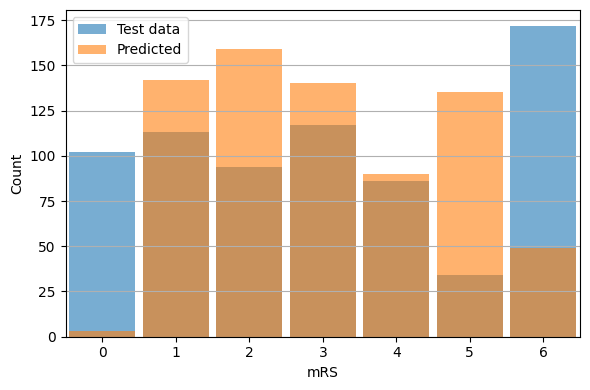

In [29]:
bins_int = np.arange(-0.5, 7.5, 1.0) 
plt.figure(figsize=(6, 4))
plt.hist(y_test,         bins=bins_int, alpha=0.6, label='Test data', rwidth=0.9)
plt.hist(np.clip(preds.loc, 0, 6), bins=bins_int, alpha=0.6, label='Predicted', rwidth=0.9)
plt.xticks(np.arange(0, 7, 1))
plt.xlim(-0.5, 6.5)
plt.xlabel('mRS')
plt.ylabel('Count') 
plt.legend(loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

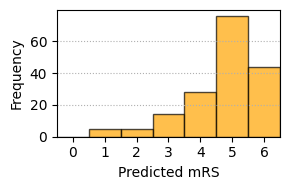

In [49]:
mask = np.asarray(y_test) == 6
vals = np.asarray(preds.loc)[mask]
pred_int = np.clip(np.round(vals).astype(int), 0, 6)
bins = np.arange(-0.5, 7.5, 1.0)

plt.figure(figsize=(3,2))
plt.hist(pred_int, bins=bins, alpha=0.7, color='orange', edgecolor='black', label='90 mRS: 6')
plt.xticks(range(7))
plt.xlim(-0.5, 6.5)
plt.xlabel('Predicted mRS')
plt.ylabel('Frequency')
# plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.grid(True, axis='y', linestyle=':')
plt.tight_layout()
plt.show()

In [20]:
def plot_residuals(y_true, y_pred, y_err):
    fig, ax = plt.subplots()
    ax.errorbar(
        y_true,
        y_true - y_pred,
        yerr=y_err,
        marker="o",
        linestyle="None",
        c="k",
        markersize=2.5,
        linewidth=0.5,
    )
    ax.axhline(0, c="k", linestyle="--")
    ax.set_xlabel("Actual data")
    ax.set_ylabel("Residuals: Actual - Predicted")
    plt.show()

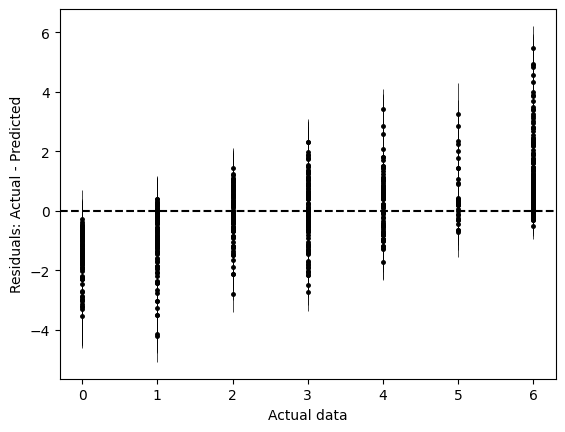

In [22]:
plot_residuals(y_test, preds.loc, preds.scale)

In [25]:
mean, std = preds.loc, preds.scale

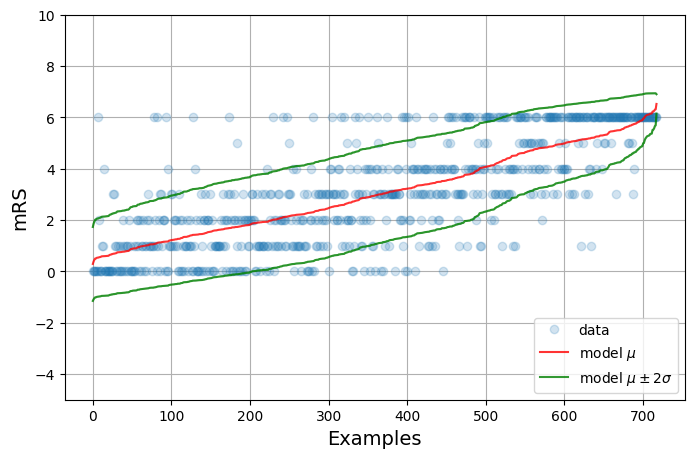

In [26]:
y_true = np.squeeze(y_test)
y_mean = np.squeeze(mean)
y_sd = np.squeeze(std)

fit_sd = np.poly1d(np.polyfit(x=y_mean, y=y_sd, deg=5))
y_sd_fit = fit_sd(y_mean)
order = np.argsort(y_mean)
y_lower = y_mean - 2*y_sd_fit
y_upper = y_mean + 2*y_sd_fit

plt.figure(figsize=(8, 5))
plt.plot(y_true[order], 'o', alpha=0.2, label='data')
plt.plot(y_mean[order], color='red', alpha=0.8, label='model $\mu$')
plt.plot(y_lower[order], color='green', alpha=0.15)
plt.plot(y_upper[order], color='green', alpha=0.15)
plt.plot(y_lower[order], color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
plt.plot(y_upper[order], color='green', alpha=0.8)
plt.xlabel('Examples', fontsize=14)
plt.ylabel('mRS', fontsize=14)
plt.ylim((-5, 10))
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Feature Importance

In [52]:
feature_names = num_names + cat_names
booster = model.get_booster()
booster.feature_names = feature_names

# Get feature importance
importance = booster.get_score(importance_type='gain')  
importance = {k: round(v, 2) for k, v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)  # Sort features by importance
features, scores = zip(*importance)  

total_score = sum(scores)
scores = [(score / total_score) * 100 for score in scores]

top_n = 20
features = features[:top_n]
scores = scores[:top_n]

In [1]:
colors = []

for feature in features:
    if feature in num_names:
        colors.append('steelblue') 
    elif feature in cat_names:
        colors.append('orange')  
    else:
        colors.append('gray')  
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(features, scores, color=colors)
ax.set_xlabel('Feature Importance (%)')
ax.set_ylabel('Features')
ax.invert_yaxis() 
for i in range(len(scores)):
    ax.text(scores[i] + 0.5, i, f'{scores[i]:.2f}%', va='center')

# Adding legend
num_patch = plt.Line2D([0], [0], color='steelblue', lw=4, label='Numerical Features')
cat_patch = plt.Line2D([0], [0], color='orange', lw=4, label='Categorical Features')
ax.legend(handles=[num_patch, cat_patch], loc='lower right')
ax.set_xlim(0, max(scores) * 1.12)
plt.show()
